# Name 1 : Prakarsh Jain
# Name 2 : Romit Bonkar


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
out_load=pickle.load(open("fp_out.sav",'rb'))
scl_load = pickle.load( open( 'fp_scl.sav', "rb" ) )

In [3]:
mi_load=pickle.load( open('fp_mi.sav', 'rb'))
f_load=pickle.load( open('fp_ftest.sav', 'rb'))

In [4]:
transformer=pickle.load( open('fp_qt.sav', 'rb'))

In [5]:
label_encoder=pickle.load(open('fp_label.sav','rb'))
to_drop=pickle.load(open('fp_noncol.sav','rb'))

In [6]:
rf=pickle.load(open('fp_rf.sav','rb'))
gb=pickle.load(open('fp_nn.sav','rb'))
knn=pickle.load(open('fp_knn.sav','rb'))

In [7]:
df=pd.read_excel('VolveData_Project.xlsx',sheet_name='well 13')

In [8]:
df.head()
df.drop(columns=['Well'],inplace=True)

In [9]:
df.set_index('Depth', inplace=True)


In [10]:
df['RHOB_Cross'] = df['RHOB'] * df['RHOB']

df['Log_GR'] =  np.log10(df.GR)

df['RT_NPHI_Ratio'] = df['RT'] / df['NPHI']

In [11]:
X=df[out_load.predict(df)==1]

In [12]:
df.columns

Index(['GR', 'RT', 'RHOB', 'NPHI', 'RHOB_Cross', 'Log_GR', 'RT_NPHI_Ratio'], dtype='object')

In [13]:
X_s=scl_load.transform(X)

In [14]:
X_s = pd.DataFrame(X_s, columns=[ 'GR', 'RT', 'RHOB', 'NPHI', 'RHOB_Cross', 'Log_GR', 'RT_NPHI_Ratio'])


In [15]:
X_nc=X_s.drop(to_drop, axis=1)

In [16]:
X_f = X_nc.loc[:,(f_load > 0.3) | (mi_load > 0.6)] #### Feature Selection using f values (f>0.3) or MI values (mi>0.6)]


In [17]:
X_f

,NPHI,RHOB_Cross,Log_GR,RT_NPHI_Ratio
0,-1.326171,1.283986,-0.595891,1.016493
1,-1.296919,1.294765,-0.546786,1.101855
2,-1.293785,1.451709,-0.496990,1.067460
3,-1.080665,1.447053,-0.175071,0.683925
4,-1.084844,1.334852,0.005610,0.836059
...,...,...,...,...
796,-0.472646,0.604659,0.784612,-0.404718
797,-0.313851,0.488331,0.847027,-0.429943
798,-0.350416,0.464710,0.774555,-0.432346
799,-0.298181,0.336066,0.730600,-0.441202


In [18]:
X_tf=transformer.transform(X_f)

In [19]:
y_pred_knn=knn.predict(X_tf)

In [20]:
y_pred_rf=rf.predict(X_tf)

In [21]:
y_pred_gb=gb.predict(X_tf)

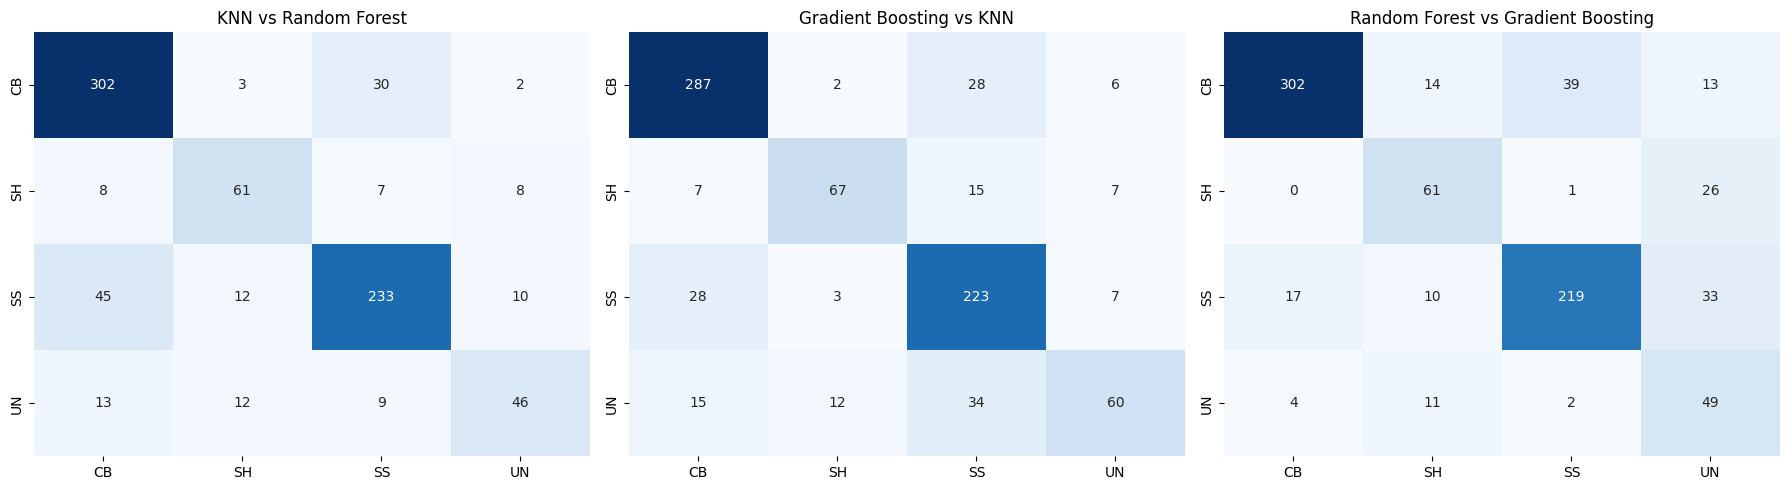

In [22]:
# Create confusion matrices
cm_knn_rf = confusion_matrix(label_encoder.inverse_transform(y_pred_knn), label_encoder.inverse_transform(y_pred_rf))
cm_knn_gb = confusion_matrix(label_encoder.inverse_transform(y_pred_gb), label_encoder.inverse_transform(y_pred_knn))
cm_rf_gb = confusion_matrix(label_encoder.inverse_transform(y_pred_rf), label_encoder.inverse_transform(y_pred_gb))

class_labels = label_encoder.classes_

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot confusion matrices
sns.heatmap(cm_knn_rf, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0], xticklabels=class_labels, yticklabels=class_labels)
axes[0].set_title('KNN vs Random Forest')

sns.heatmap(cm_knn_gb, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1], xticklabels=class_labels, yticklabels=class_labels)
axes[1].set_title('Gradient Boosting vs KNN')

sns.heatmap(cm_rf_gb, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[2], xticklabels=class_labels, yticklabels=class_labels)
axes[2].set_title('Random Forest vs Gradient Boosting')

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('classifier_comparison_knn_rf_gb.pdf')

# Display the plot
plt.show()

In [23]:
y_pred_mean = np.mean([y_pred_knn, y_pred_rf, y_pred_gb], axis=0)

# Round the mean predictions to the nearest integer (assuming classes are integers)
y_pred_mean_rounded = np.round(y_pred_mean).astype(int)


In [24]:
output=X.copy()

In [25]:
output['Mean Prediciton']=label_encoder.inverse_transform(y_pred_mean_rounded)

In [26]:
output.head()

,GR,RT,RHOB,NPHI,RHOB_Cross,Log_GR,RT_NPHI_Ratio,Mean Prediciton
Depth,,,,,,,,
4175.5,20.6032,4.1812,2.6117,0.0770,6.820977,1.313935,54.301299,CB
4176.0,21.4990,4.5516,2.6131,0.0798,6.828292,1.332418,57.037594,CB
4176.5,22.4472,4.4804,2.6334,0.0801,6.934796,1.351162,55.935081,CB
4177.0,29.6713,4.3859,2.6328,0.1005,6.931636,1.472337,43.640796,CB
4177.5,34.7014,4.8566,2.6183,0.1001,6.855495,1.540347,48.517483,CB


In [27]:
output.reset_index(inplace=True)

In [28]:
output[['Depth','Log_GR','GR','Mean Prediciton']].to_excel('Prediction.xlsx',index=False)